In [138]:
import pip
# pip.main(['install', '{insert_pckg_here}'])
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn import preprocessing

#Exploratory Data Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

#Training and testing split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
import xgboost as xg 


#Evaluation: 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

ImportError: cannot import name 'mean_absolute_percentage_error' from 'sklearn.metrics' (/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

In [72]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

## Loading Training/Testing Data:

In [73]:
train_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/train.csv'
test_url = 'https://raw.githubusercontent.com/mturner49/pylovers-final-project/dev/data/test.csv'

train_df = pd.read_csv(train_url, low_memory=False, error_bad_lines=False, index_col='Id')
test_df = pd.read_csv(test_url, low_memory=False, error_bad_lines=False, index_col='Id')
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [74]:
# This is for checking datatypes
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Data Preprocessing:

## Missing Data Imputation

In [75]:
def missing_cnt_percent(df):
    # create df that consists of columns and the number of missing values for each 
    data = df.isnull().sum().sort_values(ascending=False)
    missing_df = pd.DataFrame(data=data, columns=['missing_cnt'])

    # add column and fill it with the percentage of those missing values
    missing_df['percent_missing'] = missing_df.missing_cnt.apply(lambda x : '{:.2f}'.format(x/df.shape[0] * 100)) 
    missing_df = missing_df[missing_df.missing_cnt > 0]
    print(missing_df)

In [76]:
missing_cnt_percent(train_df)

              missing_cnt percent_missing
PoolQC               1453           99.52
MiscFeature          1406           96.30
Alley                1369           93.77
Fence                1179           80.75
FireplaceQu           690           47.26
LotFrontage           259           17.74
GarageType             81            5.55
GarageCond             81            5.55
GarageFinish           81            5.55
GarageQual             81            5.55
GarageYrBlt            81            5.55
BsmtFinType2           38            2.60
BsmtExposure           38            2.60
BsmtQual               37            2.53
BsmtCond               37            2.53
BsmtFinType1           37            2.53
MasVnrArea              8            0.55
MasVnrType              8            0.55
Electrical              1            0.07


In [77]:
# These columns has NA value that is different from null(NaN)!
train_df.update(train_df[['PoolQC']].fillna('NA'))
train_df.update(train_df[['MiscFeature']].fillna('NA'))
train_df.update(train_df[['Alley']].fillna('NA'))
train_df.update(train_df[['Fence']].fillna('NA'))
train_df.update(train_df[['FireplaceQu']].fillna('NA'))

In [78]:
# All 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond' columns has 1379 not null values!
# So, I tested the theory that exactly same rows has null for these columns!
# All 81 do not have Garage! So, we can put zero/'NA' instead!
train_df.loc[:,['GarageCars','GarageArea','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond']][train_df['GarageType'].isnull()]


,GarageCars,GarageArea,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageQual,GarageCond
Id,,,,,,,,
40,0,0,NaN,NaN,NaN,0,NaN,NaN
49,0,0,NaN,NaN,NaN,0,NaN,NaN
79,0,0,NaN,NaN,NaN,0,NaN,NaN
89,0,0,NaN,NaN,NaN,0,NaN,NaN
90,0,0,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...
1350,0,0,NaN,NaN,NaN,0,NaN,NaN
1408,0,0,NaN,NaN,NaN,0,NaN,NaN
1450,0,0,NaN,NaN,NaN,0,NaN,NaN


In [79]:
# All 81 do not have Garage! So, we can put zero/'NA' instead!
train_df.update(train_df[['GarageYrBlt','GarageCars']].fillna(0))
train_df.update(train_df[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna('NA'))

In [80]:
# Same for Basement: 'BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1'
train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtCond'].isnull()]

,TotalBsmtSF,BsmtUnfSF,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
Id,,,,,,,
18,0,0,NaN,NaN,NaN,NaN,NaN
40,0,0,NaN,NaN,NaN,NaN,NaN
91,0,0,NaN,NaN,NaN,NaN,NaN
103,0,0,NaN,NaN,NaN,NaN,NaN
157,0,0,NaN,NaN,NaN,NaN,NaN
183,0,0,NaN,NaN,NaN,NaN,NaN
260,0,0,NaN,NaN,NaN,NaN,NaN
343,0,0,NaN,NaN,NaN,NaN,NaN
363,0,0,NaN,NaN,NaN,NaN,NaN


In [81]:
# All 37 do not have Garage! So, we can put 'NA' instead!
train_df.update(train_df[['BsmtQual','BsmtCond','BsmtFinType1']].fillna('NA'))

In [82]:
# Same for Basement: 'BsmtFinType2','BsmtExposure'
train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtExposure'].isnull()]

,TotalBsmtSF,BsmtUnfSF,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
Id,,,,,,,
18,0,0,NaN,NaN,NA,NA,NA
40,0,0,NaN,NaN,NA,NA,NA
91,0,0,NaN,NaN,NA,NA,NA
103,0,0,NaN,NaN,NA,NA,NA
157,0,0,NaN,NaN,NA,NA,NA
183,0,0,NaN,NaN,NA,NA,NA
260,0,0,NaN,NaN,NA,NA,NA
343,0,0,NaN,NaN,NA,NA,NA
363,0,0,NaN,NaN,NA,NA,NA


In [83]:
train_df.at[949,'BsmtExposure']='No'

In [84]:
train_df.loc[:,['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1']][train_df['BsmtFinType2'].isnull()]

,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinType2,BsmtExposure,BsmtQual,BsmtCond,BsmtFinType1
Id,,,,,,,,
18,0,0,0,NaN,NaN,NA,NA,NA
40,0,0,0,NaN,NaN,NA,NA,NA
91,0,0,0,NaN,NaN,NA,NA,NA
103,0,0,0,NaN,NaN,NA,NA,NA
157,0,0,0,NaN,NaN,NA,NA,NA
183,0,0,0,NaN,NaN,NA,NA,NA
260,0,0,0,NaN,NaN,NA,NA,NA
333,3206,1603,479,NaN,No,Gd,TA,GLQ
343,0,0,0,NaN,NaN,NA,NA,NA


In [85]:
# I'm going with 'Average Living Quarters'
train_df.at[333,'BsmtFinType2']='ALQ'
train_df.update(train_df[['BsmtFinType2','BsmtExposure']].fillna('NA'))

In [86]:
train_df.update(train_df[['Electrical']].fillna('SBrkr'))

In [87]:
#I'm not professional but I think there is no Masonry veneer type for the Vinyl and Cement!
train_df.at[530,'MasVnrType']='Stone'

# train_df['Set_of_Numbers'] = train_df['Set_of_Numbers'].fillna(0)
train_df.update(train_df[['MasVnrArea']].fillna(0))
train_df.update(train_df[['MasVnrType']].fillna('None'))

In [88]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna((train_df['LotFrontage'].mean()))

In [89]:
missing_cnt_percent(train_df)

Empty DataFrame
Columns: [missing_cnt, percent_missing]
Index: []


## Convert categorical string to numeric

Categorical Variable Analysis for ordered categories

In [90]:
# LotShape
quality_ratings1 = {
    "IR3" : 1,
	"IR2" : 2,
	"IR1" : 3,
	"Reg" : 4
}
train_df["LotShape_Num"] = train_df.LotShape.map(quality_ratings1)
test_df["LotShape_Num"] = test_df.LotShape.map(quality_ratings1)

In [91]:
	# LandContour
quality_ratings2 = {
	"Low" : 1,
	"HLS" : 2,
	"Bnk" : 3,
	"Lvl" : 4
}
train_df["LandContour_Num"] = train_df.LandContour.map(quality_ratings2)
test_df["LandContour_Num"] = test_df.LandContour.map(quality_ratings2)

In [92]:
	# LandSlope
quality_ratings3 = {
	"Sev" : 1,
	"Mod" : 2,
	"Gtl" : 3
}
train_df["LandSlope_Num"] = train_df.LandSlope.map(quality_ratings3)
test_df["LandSlope_Num"] = test_df.LandSlope.map(quality_ratings3)

In [93]:
	# ExterQual, ExterCond, HeatingQC, KitchenQual
quality_ratings4 = {
	"Po" : 1,
	"Fa" : 2,
	"TA" : 3,
	"Gd" : 4,
	"Ex" : 5
}
train_df["ExterQual_Num"] = train_df.ExterQual.map(quality_ratings4)
train_df["ExterCond_Num"] = train_df.ExterCond.map(quality_ratings4)
train_df["HeatingQC_Num"] = train_df.HeatingQC.map(quality_ratings4)
train_df["KitchenQual_Num"] = train_df.KitchenQual.map(quality_ratings4)

test_df["ExterQual_Num"] = test_df.ExterQual.map(quality_ratings4)
test_df["ExterCond_Num"] = test_df.ExterCond.map(quality_ratings4)
test_df["HeatingQC_Num"] = test_df.HeatingQC.map(quality_ratings4)
test_df["KitchenQual_Num"] = test_df.KitchenQual.map(quality_ratings4)

In [94]:
	# BsmtQual, BsmtCond, GarageQual, GarageCond, FireplaceQu
quality_ratings5 = {
	"NA" : 1,
	"Po" : 2,
	"Fa" : 3,
	"TA" : 4,
	"Gd" : 5,
	"Ex" : 6
}
train_df["BsmtQual_Num"] = train_df.BsmtQual.map(quality_ratings5)
train_df["BsmtCond_Num"] = train_df.BsmtCond.map(quality_ratings5)
train_df["GarageQual_Num"] = train_df.GarageQual.map(quality_ratings5)
train_df["GarageCond_Num"] = train_df.GarageCond.map(quality_ratings5)
train_df["FireplaceQu_Num"] = train_df.FireplaceQu.map(quality_ratings5)

test_df["BsmtQual_Num"] = test_df.BsmtQual.map(quality_ratings5)
test_df["BsmtCond_Num"] = test_df.BsmtCond.map(quality_ratings5)
test_df["GarageQual_Num"] = test_df.GarageQual.map(quality_ratings5)
test_df["GarageCond_Num"] = test_df.GarageCond.map(quality_ratings5)
test_df["FireplaceQu_Num"] = test_df.FireplaceQu.map(quality_ratings5)

In [95]:
	# BsmtExposure
quality_ratings7 = {
	"NA" : 1,
	"No" : 2,
	"Mn" : 3,
	"Av" : 4,
	"Gd" : 5
}
train_df["BsmtExposure_Num"] = train_df.BsmtExposure.map(quality_ratings7)
test_df["BsmtExposure_Num"] = test_df.BsmtExposure.map(quality_ratings7)

In [96]:
	# BsmtFinType1, BsmtFinType2
quality_ratings8 = {
	"NA" : 1,
	"Unf" : 2,
	"LwQ" : 3,
	"Rec" : 4,
	"BLQ" : 5,
	"ALQ" : 6,
	"GLQ" : 7
}
train_df["BsmtFinType1_Num"] = train_df.BsmtFinType1.map(quality_ratings8)
train_df["BsmtFinType2_Num"] = train_df.BsmtFinType2.map(quality_ratings8)

test_df["BsmtFinType1_Num"] = test_df.BsmtFinType1.map(quality_ratings8)
test_df["BsmtFinType2_Num"] = test_df.BsmtFinType2.map(quality_ratings8)

In [97]:
	# Functional
quality_ratings9 = {
	"Sal" : 1,
	"Sev" : 2,
	"Maj2" : 3,
	"Maj1" : 4,
	"Mod" : 5,
	"Min2" : 6,
	"Min1" : 7,
	"Typ" : 8
}
train_df["Functional_Num"] = train_df.Functional.map(quality_ratings9)

test_df["Functional_Num"] = test_df.Functional.map(quality_ratings9)

In [98]:
	# GarageFinish
quality_ratings10 = {
	"NA" : 1,
	"Unf" : 2,
	"RFn" : 3,
	"Fin" : 4
}
train_df["GarageFinish_Num"] = train_df.GarageFinish.map(quality_ratings10)

test_df["GarageFinish_Num"] = test_df.GarageFinish.map(quality_ratings10)

In [99]:
	# CentralAir
quality_ratings11 = {
	"N" : 1,
	"Y" : 2
}
train_df["CentralAir_Num"] = train_df.CentralAir.map(quality_ratings11)

test_df["CentralAir_Num"] = test_df.CentralAir.map(quality_ratings11)

In [100]:
	# PavedDrive
quality_ratings12 = {
	"N" : 1,
	"P" : 2,
	"Y" : 3
}
train_df["PavedDrive_Num"] = train_df.PavedDrive.map(quality_ratings12)

test_df["PavedDrive_Num"] = test_df.PavedDrive.map(quality_ratings12)

In [101]:
	# PoolQC
quality_ratings6 = {
	"NA" : 1,
	"Fa" : 2,
	"TA" : 3,
	"Gd" : 4,
	"Ex" : 5
}
train_df["PoolQC_Num"] = train_df.PoolQC.map(quality_ratings6)
test_df["PoolQC_Num"] = test_df.PoolQC.map(quality_ratings6)

In [102]:
	# MSSubClass
quality_ratings7 = {
    20:"St46nNAS", 
    30:"St45nOl", 
    40:"StwFinAAA", 
    45:"HalfStUnfinAAA", 
    50:"HalfStFinAA",
    60:"St46nN", 
    70:"St45nOl", 
    75:"HalfStAA", 
    80:"SplorML", 
    85:"SplFoy", 
    90:"DupASnA", 
    120:"StPud46nN", 
    150:"HalfStPudAA", 
    160:"StPud46nNN", 
    180:"PudML", 190:"FamConv"
}
train_df["MSSubClass_Cat"] = train_df.MSSubClass.map(quality_ratings7)
test_df["MSSubClass_Cat"] = test_df.MSSubClass.map(quality_ratings7)

In [103]:
# drop the columns where we replaced with numbers
drop_cols = ['ExterQual', 'BsmtQual', 'HeatingQC', 'KitchenQual','GarageQual','LotShape','LandContour','LandSlope','ExterCond','BsmtCond','GarageCond','FireplaceQu','BsmtExposure','BsmtFinType1','BsmtFinType2','Functional','GarageFinish','CentralAir','PavedDrive','PoolQC','MSSubClass']

for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [104]:
train_df.SalePrice

Id
1       208500
2       181500
3       223500
4       140000
5       250000
         ...  
1456    175000
1457    210000
1458    266500
1459    142125
1460    147500
Name: SalePrice, Length: 1460, dtype: int64

## Exploratory Data Analysis (EDA)

In [105]:
train_df.columns

Index(['MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'Utilities',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold',
       'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'LotShape_Num',
       'LandContour_Num', 'LandSlope_Num', 'ExterQual_Num', 'ExterCond_Num',
       'HeatingQC_Num'

- Correlation 

In [106]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
corr_matrix['SalePrice'].sort_values(ascending=False)

SalePrice           1.0000
OverallQual         0.7910
GrLivArea           0.7086
ExterQual_Num       0.6826
KitchenQual_Num     0.6596
GarageCars          0.6404
GarageArea          0.6234
TotalBsmtSF         0.6136
1stFlrSF            0.6059
BsmtQual_Num        0.5852
FullBath            0.5607
GarageFinish_Num    0.5492
TotRmsAbvGrd        0.5337
YearBuilt           0.5229
FireplaceQu_Num     0.5204
YearRemodAdd        0.5071
MasVnrArea          0.4726
Fireplaces          0.4669
HeatingQC_Num       0.4276
BsmtFinSF1          0.3864
BsmtExposure_Num    0.3750
LotFrontage         0.3349
WoodDeckSF          0.3244
2ndFlrSF            0.3193
OpenPorchSF         0.3159
BsmtFinType1_Num    0.3049
HalfBath            0.2841
GarageQual_Num      0.2738
LotArea             0.2638
GarageCond_Num      0.2632
GarageYrBlt         0.2614
CentralAir_Num      0.2513
PavedDrive_Num      0.2314
BsmtFullBath        0.2271
BsmtUnfSF           0.2145
BsmtCond_Num        0.2126
BedroomAbvGr        0.1682
P

In [107]:
corr_matrix[(corr_matrix.SalePrice<0.05) & (corr_matrix.SalePrice>-0.05)].SalePrice.sort_values(ascending=False)

MoSold              0.0464
3SsnPorch           0.0446
ExterCond_Num       0.0189
BsmtFinType2_Num   -0.0003
BsmtFinSF2         -0.0114
BsmtHalfBath       -0.0168
MiscVal            -0.0212
LowQualFinSF       -0.0256
YrSold             -0.0289
Name: SalePrice, dtype: float64

In [108]:
train_df['TotSF_Factor'] = train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']
train_df["AddedArea_Factor"] = train_df["GrLivArea"] + train_df["GarageArea"]
train_df["TotBath_Factor"] = train_df["FullBath"] + (train_df["HalfBath"]*0.5)
train_df['Overall_Factor'] = train_df['OverallQual'] * train_df['OverallCond'] * train_df['YearBuilt']
train_df['Yr_Factor'] = train_df['YrSold'] - np.maximum(train_df['YearBuilt'],train_df['YearRemodAdd'])
train_df['Pool_Factor'] = train_df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_df['OpenOR3SsnPorch_Factor'] = train_df["OpenPorchSF"].apply(lambda x: 1 if x > 0 else 0) + train_df["3SsnPorch"].apply(lambda x: 1 if x > 0 else 0) + train_df["WoodDeckSF"].apply(lambda x: 1 if x > 0 else 0)
train_df['Kitchen2Flr_Ratio'] = train_df['KitchenAbvGr'] / (train_df['1stFlrSF'].apply(lambda x: 1 if x > 0 else 0) + train_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0) + train_df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0))

## Not high corr
# train_df['BathPerBedRoom_Factor'] = train_df['FullBath'] / (train_df['BedroomAbvGr']+0.01)
# train_df['BsmtFin2TotBsmtSF_Ratio'] = (train_df['BsmtFinSF1']+train_df['BsmtFinSF2']) / (train_df['TotalBsmtSF']+0.01)
# train_df["Age_factor"] = train_df["YearRemodAdd"] - train_df["YearBuilt"]
# train_df['Options_Factor'] =train_df['Porch_Factor'] + train_df['BathPerRoom_Factor'] + train_df['Pool_Factor']  + train_df["Bsmt_factor"]
# train_df['GarageCars2Area_Ratio'] = train_df['GarageCars'] / (train_df['GarageArea']+0.01)
# train_df['Porch_Factor'] = (train_df['OpenPorchSF'] + train_df['EnclosedPorch']+ train_df['3SsnPorch']+ train_df['ScreenPorch']+0.01)
# train_df['2ndFlr_Factor'] = train_df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
# train_df["Bsmt_factor"] = train_df["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
# train_df['TotGrLiv2Lot_Ratio'] = train_df['GrLivArea'] / (train_df['LotArea']+0.01)
# train_df['TotSF2Lot_Ratio'] = (train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']) / (train_df['LotArea']+0.01)
# train_df['TotBsmtBath2BsmtSF_Ratio'] = (train_df['BsmtFullBath'] + train_df['BsmtHalfBath'])/(train_df['TotalBsmtSF']+0.01)
# train_df['ClosePorch_Factor'] = train_df['ScreenPorch'] + train_df['EnclosedPorch']
# train_df['LowQualFin2TotSF_Ratio'] = train_df['LowQualFinSF'] / (train_df['1stFlrSF']+train_df['2ndFlrSF']+train_df['TotalBsmtSF']+0.01)

In [109]:
drop_cols = ['MoSold','3SsnPorch','ExterCond_Num','BsmtFinType2_Num','BsmtFinSF2','BsmtHalfBath','MiscVal','LowQualFinSF','YrSold','Street','Utilities','LandSlope_Num','PoolQC_Num','MiscFeature']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [110]:
corr_matrix = train_df.corr()
corr_matrix['SalePrice'] = round(corr_matrix['SalePrice'],4)
print_full(corr_matrix['SalePrice'].sort_values(ascending=False))

SalePrice                 1.0000
OverallQual               0.7910
TotSF_Factor              0.7823
AddedArea_Factor          0.7736
GrLivArea                 0.7086
ExterQual_Num             0.6826
KitchenQual_Num           0.6596
GarageCars                0.6404
GarageArea                0.6234
TotalBsmtSF               0.6136
1stFlrSF                  0.6059
TotBath_Factor            0.5980
Overall_Factor            0.5938
BsmtQual_Num              0.5852
FullBath                  0.5607
GarageFinish_Num          0.5492
TotRmsAbvGrd              0.5337
YearBuilt                 0.5229
FireplaceQu_Num           0.5204
YearRemodAdd              0.5071
MasVnrArea                0.4726
OpenOR3SsnPorch_Factor    0.4707
Fireplaces                0.4669
HeatingQC_Num             0.4276
BsmtFinSF1                0.3864
BsmtExposure_Num          0.3750
LotFrontage               0.3349
WoodDeckSF                0.3244
2ndFlrSF                  0.3193
OpenPorchSF               0.3159
BsmtFinTyp

In [111]:
corr_matrix[(corr_matrix.SalePrice<0.1) & (corr_matrix.SalePrice>-0.1)].SalePrice.sort_values(ascending=False)

Pool_Factor        0.0937
PoolArea           0.0924
LandContour_Num   -0.0730
OverallCond       -0.0779
Name: SalePrice, dtype: float64

In [112]:
drop_cols = ['KitchenAbvGr','PoolArea','OpenPorchSF','LandContour_Num','EnclosedPorch','ScreenPorch','OverallCond','FullBath','HalfBath']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

- Variance Inflation Factor

In [113]:
num_features = [col for col in train_df.columns if train_df[col].dtypes != 'O' and col not in "Id"]
train_df_vif = train_df.loc[:,train_df.columns.isin(num_features)]

In [114]:
X = add_constant(train_df_vif)
print_full(pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])], index=X.columns))

const                     2.433499e+06
LotFrontage               1.439343e+00
LotArea                   1.394992e+00
OverallQual               6.996395e+00
YearBuilt                 5.058669e+00
YearRemodAdd              2.546198e+02
MasVnrArea                1.438530e+00
BsmtFinSF1                9.959697e+00
BsmtUnfSF                 9.284505e+00
TotalBsmtSF                        inf
1stFlrSF                           inf
2ndFlrSF                           inf
GrLivArea                          inf
BsmtFullBath              2.158798e+00
BedroomAbvGr              2.424385e+00
TotRmsAbvGrd              4.763025e+00
Fireplaces                4.719187e+00
GarageYrBlt               1.392743e+01
GarageCars                6.324242e+00
GarageArea                         inf
WoodDeckSF                1.745717e+00
SalePrice                 5.718933e+00
LotShape_Num              1.241083e+00
ExterQual_Num             3.173202e+00
HeatingQC_Num             1.720778e+00
KitchenQual_Num          

In [115]:
drop_cols = ['GrLivArea','2ndFlrSF']
for col in drop_cols:
    train_df.drop(col, axis=1, inplace=True)
    test_df.drop(col, axis=1, inplace=True)

In [116]:
num_features = [col for col in train_df.columns if train_df[col].dtypes != 'O' and col not in "Id"]
train_df_vif = train_df.loc[:,train_df.columns.isin(num_features)]

In [117]:
X = add_constant(train_df_vif)
print_full(pd.Series([variance_inflation_factor(X.values, i)
          for i in range(X.shape[1])], index=X.columns))

const                     2.433499e+06
LotFrontage               1.439343e+00
LotArea                   1.394992e+00
OverallQual               6.996395e+00
YearBuilt                 5.058669e+00
YearRemodAdd              2.546198e+02
MasVnrArea                1.438530e+00
BsmtFinSF1                9.959697e+00
BsmtUnfSF                 9.284505e+00
TotalBsmtSF               1.047828e+02
1stFlrSF                  7.138822e+00
BsmtFullBath              2.158798e+00
BedroomAbvGr              2.424385e+00
TotRmsAbvGrd              4.763025e+00
Fireplaces                4.719187e+00
GarageYrBlt               1.392743e+01
GarageCars                6.324242e+00
GarageArea                2.813412e+01
WoodDeckSF                1.745717e+00
SalePrice                 5.718933e+00
LotShape_Num              1.241083e+00
ExterQual_Num             3.173202e+00
HeatingQC_Num             1.720778e+00
KitchenQual_Num           2.733500e+00
BsmtQual_Num              4.608338e+00
BsmtCond_Num             

## Outliers Analysis:

In [118]:
def outlier_thresholds(df, var):
    quartile1 = df[var].quantile(0.05)
    quartile3 = df[var].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def has_outliers(df, num_col_names):
    var_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(df, col)
        if df[(df[col] > up_limit) | (df[col] < low_limit)].any(axis=None):
            number_of_outliers = df[(df[col] > up_limit) | (df[col] < low_limit)].shape[0]
            var_names.append(col)
    return var_names

def replace_with_thresholds(df, var):
    low_limit, up_limit = outlier_thresholds(df, var)
    df.loc[(df[var] < low_limit), var] = low_limit
    df.loc[(df[var] > up_limit), var] = up_limit

In [119]:
has_outliers(train_df, num_features)

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'BsmtFullBath',
 'BedroomAbvGr',
 'WoodDeckSF',
 'SalePrice',
 'LotShape_Num',
 'BsmtCond_Num',
 'Functional_Num',
 'TotSF_Factor',
 'AddedArea_Factor',
 'Pool_Factor',
 'Kitchen2Flr_Ratio']

In [120]:
for col in num_features:
    replace_with_thresholds(train_df, col)

has_outliers(train_df, num_features)

[]

In [121]:
train_df.SalePrice

Id
1       208500.0
2       181500.0
3       223500.0
4       140000.0
5       250000.0
          ...   
1456    175000.0
1457    210000.0
1458    266500.0
1459    142125.0
1460    147500.0
Name: SalePrice, Length: 1460, dtype: float64

## Categorical Variable Analysis for non-ordered categories

In [122]:
train_df = pd.get_dummies(data = train_df, columns = ["SaleCondition", "MSSubClass_Cat", "MSZoning", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", 
        "Exterior2nd", "MasVnrType", "Foundation", "Heating", "Electrical", "GarageType", "SaleType", "Fence", "Alley"] , drop_first=True)

In [123]:
train_df.SalePrice

Id
1       208500.0
2       181500.0
3       223500.0
4       140000.0
5       250000.0
          ...   
1456    175000.0
1457    210000.0
1458    266500.0
1459    142125.0
1460    147500.0
Name: SalePrice, Length: 1460, dtype: float64

## Split data set into train dataset and test dataset 

In [124]:
#Independent variable:
x= train_df.loc[:,~train_df.columns.isin(['Id','SalePrice'])]

#dependent variable:
y=train_df.loc[:,'SalePrice']

In [125]:
x_train, x_test, y_train, y_test= train_test_split(x,y,test_size=0.3,random_state=42)

# Standardization 

In [126]:
#Independent variable:
X= train_df.loc[:,~train_df.columns.isin(['Id','SalePrice'])]

#dependent variable:
Y=train_df[['SalePrice']]

In [127]:
sc_X = StandardScaler()
sc_Y = StandardScaler()

In [128]:
X = sc_X.fit_transform(X)
Y = sc_X.fit_transform(Y)

In [129]:
x_s_train, x_s_test, y_s_train, y_s_test= train_test_split(X,Y,test_size=0.3,random_state=42)

# Model

In [139]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

## Linear Regression

In [ ]:
ln_reg=LinearRegression()

In [ ]:
ln_reg.fit(x_train,y_train)

In [ ]:
ln_y_pred=ln_reg.predict(x_test)

In [ ]:
print('MAPE = ', mean_absolute_percentage_error(y_test,ln_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,ln_y_pred),
      '\nr2_score = ', r2_score(y_test,ln_y_pred))

## Decision Tree

In [ ]:
regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(x_train, y_train)

In [ ]:
dt_y_pred=regressor_dt.predict(x_test)

In [ ]:
# mean_absolute_percentage_error(y_test,dt_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,dt_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,dt_y_pred),
      '\nr2_score = ', r2_score(y_test,dt_y_pred))

- With Scaled Data

In [ ]:
regressor_dt = DecisionTreeRegressor()
regressor_dt.fit(x_s_train, y_s_train)

In [ ]:
dts_y_pred=regressor_dt.predict(x_s_test)

In [ ]:
mean_absolute_percentage_error(y_s_test,dts_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,dts_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,dts_y_pred),
      '\nr2_score = ', r2_score(y_test,dts_y_pred))

## SVR

In [ ]:
svr_regressor = SVR(kernel = 'rbf')

In [ ]:
svr_regressor.fit(x_train,y_train)

In [ ]:
svr_y_pred = svr_regressor.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test,svr_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_y_pred))


- kernel = rbf


In [ ]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf.fit(x_train,y_train)

In [ ]:
svr_rbf_y_pred = svr_rbf.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test,svr_rbf_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_rbf_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_rbf_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_rbf_y_pred))

- kernel = linear

In [ ]:
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_lin.fit(x_train,y_train)

In [ ]:
svr_lin_y_pred = svr_lin.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test,svr_lin_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_lin_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_lin_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_lin_y_pred))

- kernel = poly

In [ ]:
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)
svr_poly.fit(x_train,y_train)

In [ ]:
svr_poly_y_pred = svr_poly.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test,svr_poly_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,svr_poly_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,svr_poly_y_pred),
      '\nr2_score = ', r2_score(y_test,svr_poly_y_pred))

## Random Forest

In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_train,y_train)

In [ ]:
rf_y_pred=rf_regressor.predict(x_test)

In [ ]:
mean_absolute_percentage_error(y_test,rf_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,rf_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,rf_y_pred),
      '\nr2_score = ', r2_score(y_test,rf_y_pred))

- With Scaled Data

In [ ]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(x_s_train,y_s_train)

In [ ]:
rf_s_y_pred=rf_regressor.predict(x_s_test)

In [ ]:
mean_absolute_percentage_error(y_s_test,rf_s_y_pred)
print('MAPE = ', mean_absolute_percentage_error(y_test,rf_s_y_pred), 
      '\nMSE = ', mean_squared_error(y_test,rf_s_y_pred),
      '\nr2_score = ', r2_score(y_test,rf_s_y_pred))

## XGBoost Regression:

In [155]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 275, seed = 123,
                        subsample=0.75, learning_rate=0.1)

In [156]:
# Fitting the model 
xgb_r.fit(x_train, y_train) 
  
# Predict the model 
pred = xgb_r.predict(x_test) 
  
# RMSE 
rmse = mean_squared_error(y_test, pred, squared=False)

# variance score
var_score = explained_variance_score(y_test, pred)

# MAPE
mape = mean_absolute_percentage_error(y_test, pred)

print("Test RMSE: %.2f" %(rmse)) 
print("variance score: %.2f" %(var_score))
print("MAPE: %.2f" %(mape) + '%')

Test RMSE: 24780.20
variance score: 0.91
MAPE: 8.87%


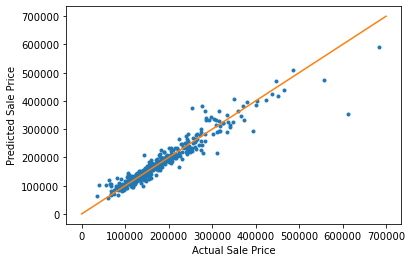

In [162]:
# plot predicted price vs actual price
plt.plot(y_test, pred, '.')

x = np.linspace(0, 700000)
y = x
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.plot(x, y)
plt.show()

In [148]:
out_df = x_test.copy()
out_df['Actual_Target'] = y_test
out_df['Predicted_Target'] = pred
out_df.head(30)

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_Oth,SaleType_WD,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_NA,Alley_NA,Alley_Pave,Actual_Target,Predicted_Target
Id,,,,,,,,,,,,,,,,,,,,,
893,70.000000,8414.0,6.0,1963.0,2003.0,0.0,663.0,396.0,1059.0,1068.0,...,0,1,0,1,0,0,1,0,154500.0,141579.531250
1106,98.000000,12256.0,8.0,1994.0,1995.0,362.0,1032.0,431.0,1463.0,1500.0,...,0,1,0,0,0,1,1,0,325000.0,335509.250000
414,56.000000,8960.0,5.0,1927.0,1950.0,0.0,0.0,1008.0,1008.0,1028.0,...,0,1,0,0,0,1,0,0,115000.0,110921.437500
523,50.000000,5000.0,6.0,1947.0,1950.0,0.0,399.0,605.0,1004.0,1004.0,...,0,1,0,0,0,1,1,0,159000.0,154466.937500
1037,89.000000,12898.0,9.0,2007.0,2008.0,70.0,1022.0,598.0,1620.0,1620.0,...,0,1,0,0,0,1,1,0,315500.0,316527.625000
615,21.000000,1491.0,4.0,1972.0,1972.0,0.0,150.0,0.0,630.0,630.0,...,0,1,0,0,0,1,1,0,75500.0,70032.000000
219,70.049958,15660.0,7.0,1939.0,2006.0,312.0,341.0,457.0,798.0,1137.0,...,0,1,0,0,0,1,1,0,311500.0,219384.109375
1161,24.000000,2280.0,6.0,1978.0,1978.0,0.0,311.0,544.0,855.0,855.0,...,0,1,0,0,0,1,1,0,146000.0,155090.078125
650,21.000000,1936.0,4.0,1970.0,1970.0,0.0,131.0,0.0,630.0,630.0,...,0,1,0,1,0,0,1,0,84500.0,70909.140625


## Data Exploration:

## Data Visualization (CAN BE DELETED):